In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score # AUC score
from sklearn.metrics import average_precision_score # AUPR score
from sklearn.metrics import precision_recall_fscore_support # precision, recall
from imblearn.metrics import sensitivity_specificity_support # sensitivity, specificity
from sklearn.metrics import roc_curve # to draw auc curve
from sklearn.metrics import precision_recall_curve # to draw aupr curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#2017.3.24. removed bayesian TN descriptor
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/8_2_1_tn_whole_descriptor_removed_bayesian.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [3]:
# undersampler
rus = RandomUnderSampler()
oss = OneSidedSelection()
nm = NearMiss()

In [4]:
def Random_Forest_K_fold_graph(X, y, k, user_estimator):
    
    skf = StratifiedKFold(n_splits=k, shuffle=True) # n_splits = k (k fold라서.), pos:neg의 비율을 고려해서 k 개의 subgroup으로 나누어줌.
    folds_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    for training_index, validation_index in skf.split(X, y):
        x_training_set = X[training_index]
        y_training_set = y[training_index]
        x_validation_set = X[validation_index]
        y_validation_set = y[validation_index]
        
        classifier = RandomForestClassifier(n_estimators=user_estimator, n_jobs=-1, class_weight='balanced') #n_jobs=-1 이면 모든 node 쓰는것, 신경쓰이면 30개 정도.
        classifier.fit(x_training_set, y_training_set)
        
        y_predicted_proba = classifier.predict_proba(x_validation_set) # [0에 대한 확률, 1에 대한 확률], shpae = [n_samples, n_class]
        y_predicted_label = classifier.predict(x_validation_set) # 예측된 label을 보여줌, shpae = [n_samples]
        
        # Accuracy 
        current_acc = classifier.score(x_validation_set, y_validation_set)
        folds_results['acc'].append(current_acc)

        # AUC
        current_auc = roc_auc_score(y_validation_set, y_predicted_proba[:,1])
        folds_results['auc'].append(current_auc)
        
        # Sensitivity, Specificity
        sn, sp, support = sensitivity_specificity_support(y_validation_set, y_predicted_label)
        folds_results['sn'].append(sn)
        folds_results['sp'].append(sp)
        
        # AUPR
        current_aupr = average_precision_score(y_validation_set, y_predicted_label)
        folds_results['aupr'].append(current_aupr)
        
        # Precision, Recall
        precision, recall, _, _ =  precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
        folds_results['precision'].append(precision)
        folds_results['recall'].append(recall)
        
        # Confusion Matrix
        current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
        folds_results['confusion_matrix'].append(current_confusion_matrix)
        
        #draw graph
        fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1)
        draw_results['fpr'].append(fpr)
        draw_results['tpr'].append(tpr)
        
        precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1])
        draw_results['precision_vec'].append(precision_vec)
        draw_results['recall_vec'].append(recall_vec)
        
    return folds_results, draw_results

In [5]:
def draw_plot(draw_results, final_result, user_estimator):
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
    lw = 1
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    print "{}------------------------------------".format(user_estimator)
    for i in draw_results:
        for fpr, tpr in zip(i['fpr'], i['tpr']):
            ax1.plot(fpr, tpr, lw=lw)
        for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
            ax2.plot(recall_vec, precision_vec, lw=lw)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_color_cycle(colors)
    ax1.set_title('N={0}, Average AUC={1:0.2f}'.format(user_estimator, final_result['auc']))
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_color_cycle(colors)
    ax2.set_title('N={0}, Average AUPR={1:0.2f}'.format(user_estimator, final_result['aupr']))
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    plt.tight_layout()
    plt.show()

In [6]:
def average_result(folds_results):
    avg_result = dict()
    avg_result['avg_acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
    avg_result['avg_auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
    avg_result['avg_aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
    avg_result['avg_sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
    avg_result['avg_sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
    avg_result['avg_precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
    avg_result['avg_recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
    avg_result['sum_confusion_matrix'] = sum(folds_results['confusion_matrix'])
    
    return avg_result

In [7]:
def independent_results(param_result):
    indep_results = {'indep_acc':[], 'indep_auc':[], 'indep_aupr':[], 'indep_confusion_matrix':[],
                     'indep_sn':[], 'indep_sp':[], 'indep_precision':[], 'indep_recall':[]}
    for fold in param_result:
        indep_results['indep_acc'].append(fold['avg_acc'])
        indep_results['indep_auc'].append(fold['avg_auc'])
        indep_results['indep_aupr'].append(fold['avg_aupr'])
        indep_results['indep_sn'].append(fold['avg_sn'])
        indep_results['indep_sp'].append(fold['avg_sp'])
        indep_results['indep_precision'].append(fold['avg_precision'])
        indep_results['indep_recall'].append(fold['avg_recall'])
        indep_results['indep_confusion_matrix'].append(fold['sum_confusion_matrix'])
    return indep_results

In [8]:
def final_results (indep_results):
    results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[],
               'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    results['acc'] = sum(indep_results['indep_acc']) / len(indep_results['indep_acc'])
    results['auc'] = sum(indep_results['indep_auc']) / len(indep_results['indep_auc'])
    results['aupr'] = sum(indep_results['indep_aupr']) / len(indep_results['indep_aupr'])
    results['sn'] = sum(indep_results['indep_sn']) / len(indep_results['indep_sn'])
    results['sp'] = sum(indep_results['indep_sp']) / len(indep_results['indep_sp'])
    results['precision'] = sum(indep_results['indep_precision']) / len(indep_results['indep_precision'])
    results['recall'] = sum(indep_results['indep_recall']) / len(indep_results['indep_recall'])
    results['confusion_matrix'] = sum(indep_results['indep_confusion_matrix'])
    return results

In [13]:
def write_output(fd, write_results, user_estimator):
    fd.write("n_estimator={}-------------------------------------------------\r\n".format(user_estimator))
    fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
    fd.write("AUC avg : {}\r\n".format(write_results['auc']))
    fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
    fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
    fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
    fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
    fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
    fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))

2017-03-24 15:40:31
120------------------------------------


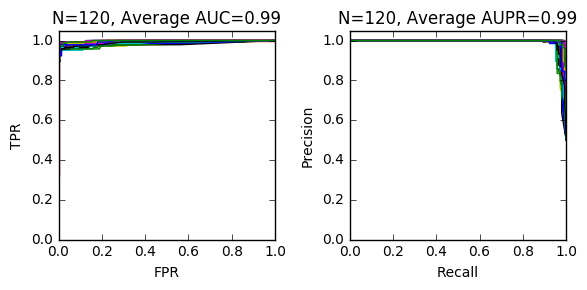

300------------------------------------


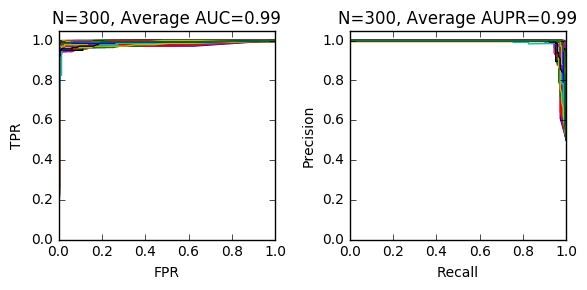

500------------------------------------


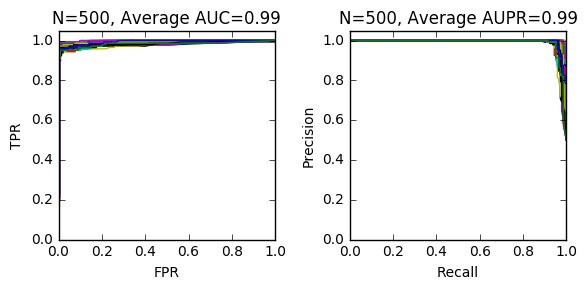

800------------------------------------


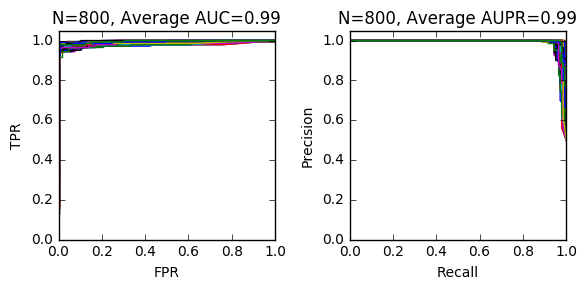

1200------------------------------------


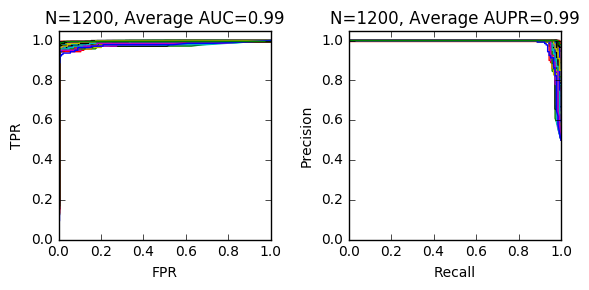

2017-03-24 15:40:33


In [16]:
# Independent RandomForest_K_fold_grpah + 파일 입출력
# removed descriptor, bayesian, tn(whole) 10-fold, 1:1  2017.3.24. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/'
with open(path + "2_11_RF_removed_bayesian_TN_whole_(pos_neg)_10-fold.txt", 'w') as fd :
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 10 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
def Random_Forest_K_fold(X, y, k, user_estimator):
    
    skf = StratifiedKFold(n_splits=k, shuffle=True) # n_splits = k (k fold라서.), pos:neg의 비율을 고려해서 k 개의 subgroup으로 나누어줌.
    folds_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    
    for training_index, validation_index in skf.split(X, y):
        x_training_set = X[training_index]
        y_training_set = y[training_index]
        x_validation_set = X[validation_index]
        y_validation_set = y[validation_index]
        
        classifier = RandomForestClassifier(n_estimators=user_estimator, n_jobs=-1, class_weight='balanced') #n_jobs=-1 이면 모든 node 쓰는것, 신경쓰이면 30개 정도.
        classifier.fit(x_training_set, y_training_set)
        
        y_predicted_proba = classifier.predict_proba(x_validation_set) # [0에 대한 확률, 1에 대한 확률], shpae = [n_samples, n_class]
        y_predicted_label = classifier.predict(x_validation_set) # 예측된 label을 보여줌, shpae = [n_samples]
        
        # Accuracy 
        current_acc = classifier.score(x_validation_set, y_validation_set)
        folds_results['acc'].append(current_acc)

        # AUC
        current_auc = roc_auc_score(y_validation_set, y_predicted_proba[:,1])
        folds_results['auc'].append(current_auc)
        
        # Sensitivity, Specificity
        sn, sp, support = sensitivity_specificity_support(y_validation_set, y_predicted_label)
        folds_results['sn'].append(sn)
        folds_results['sp'].append(sp)
        
        # AUPR
        current_aupr = average_precision_score(y_validation_set, y_predicted_label)
        folds_results['aupr'].append(current_aupr)
        
        # Precision, Recall
        precision, recall, _, _ =  precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
        folds_results['precision'].append(precision)
        folds_results['recall'].append(recall)
        
        # Confusion Matrix
        current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
        folds_results['confusion_matrix'].append(current_confusion_matrix)
    
    return folds_results

In [ ]:
# Independent RandomForest_K_fold_grpah + 파일 입출력
# removed descriptor, bayesian, tn(whole) 10-fold, 1:1  2017.3.24. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/'
with open(path + "2_11_RF_removed_bayesian_TN_whole_(pos_neg)_10-fold.txt", 'w') as fd :
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 10 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# independent RandomForest_K_fold + 파일 입출력
# removed descriptor, bayesian, tn(whole) 10-fold, 1:1  2017.3.21. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/'
with open(path + "2_11_RF_removed_bayesian_TN_whole_(pos_neg)_10-fold.txt", 'w') as fd :
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 10 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            avg_result = average_results(Random_Forest_K_fold(x_resampled, y_resampled, k, user_estimator))
            param_results[user_estimator].append(avg_result) # parameter 별로 k-fold cv 한 결과 저장

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# independent RandomForest_K_fold_graph test 코드
# independent 10-fold cv
param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
independent_count = 3 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
k = 3 # k-fold cv
for i in range(independent_count):
    x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
    for user_estimator in [120,300,500,800,1200]:
        folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
        avg_result = average_result(folds_results) # parameter 별로 k-fold한 결과의 average를 구한다.
        param_results[user_estimator].append(avg_result) # parameter 별로 independent 결과를 저장한다.
        draw_total[user_estimator].append(draw_results)
        
final_param_results =  {120:[], 300:[], 500:[], 800:[], 1200:[]}
for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
    indep_results = independent_results(param_results[user_estimator])
    final_param_results[user_estimator] = final_results(indep_results)
    draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)

In [ ]:
#draw graph Test 용 코드
lw = 1
plt.clf()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
for fpr, tpr in zip(draw_results['fpr'], draw_results['tpr']):
    ax1.plot(fpr, tpr, lw=lw)
for recall_vec, precision_vec in zip(draw_results['recall_vec'], draw_results['precision_vec']):
    ax2.plot(recall_vec, precision_vec, lw=lw)
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
ax1.set_color_cycle(colors)
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
#ax1.set_title('AUC')
ax1.set_title('N={0}, Average AUC={1:0.2f}'.format(user_estimator, final_param_results[user_estimator]['auc']))
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_color_cycle(colors)
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
#ax2.set_title('AUPR')
ax2.set_title('N={0}, Average AUPR={1:0.2f}'.format(user_estimator, final_param_results[user_estimator]['aupr']))
plt.tight_layout()